## **0. 사전 설치 리스트**

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pandas-profiling==2.*
    !sudo apt-get install -y fonts-nanum 
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

In [1]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

## **1. 2018 ~ 20년도 교통 문화 실태조사 데이터 합치기**

**주요 진행 항목**

- 18 ~ 20년도 컬럼명 통일
- 같은 내용을 담는 컬럼의 데이터 값 통일
- 결측치 처리

출처 : https://mdis.kostat.go.kr/extract/extYearsSurvSearchNew.do?curMenuNo=UI_POR_P9012

(키워드 : 건설/교통·물류 -> 교통문화실태조사)

In [12]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session2/Example_data/session2_project/'
CSV_LIST = ['의식수준 설문조사_2018.csv', '의식수준 설문조사_2019.csv', '의식수준 설문조사_2020.csv']

# 불러오기
car_sur_2018 = pd.read_csv(PATH + CSV_LIST[0], sep=',', encoding = "cp949")
car_sur_2019 = pd.read_csv(PATH + CSV_LIST[1], sep=',', encoding = "cp949")
car_sur_2020 = pd.read_csv(PATH + CSV_LIST[2], sep=',', encoding = "cp949")

# 형태 확인
car_sur_2018.shape, car_sur_2019.shape, car_sur_2020.shape

((24274, 64), (24274, 64), (24274, 88))

### **1-1. 칼럼 삭제 방향성**

- 3개년 설문에 공통으로 포함되어 있지 않은 칼럼 삭제
- 결측치가 절대 다수인 칼럼 삭제
- 주제와의 관련성이 없는 칼럼 삭제

In [13]:
# 18 ~ 20년도 공통으로 적용할 drop list 
drop_all = ['문3. 귀하는 현재 자동차를 운전 하십니까', '문5-1. 귀하는 오토바이를 이용하십니까', '문5-2. 귀하는 지난 30일 간 오토바이 운전 시 안전모 착용을 위반한 경험이 있으십니까',
        '문5-3. 귀하는 오토바이 운전 시 안전모 착용을 반드시 착용해야 된다고 생각하십니까', '문6-1. 귀하는 지난 30일 간 오토바이 운전 시 인도 및 횡단보도를 이용하여 통행방법을 위반한 경험이 있으십니까',
        '문6-2. 귀하는 오토바이 운전 시 인도 및 횡단보도를 통행하지 않아야 된다고 생각하십니까', '문9-3. 귀하께서 지난 30일간 운전 중 한 번이라도 한 행동은 무엇입니까_2', '문9-3. 귀하께서 지난 30일간 운전 중 한 번이라도 한 행동은 무엇입니까_3',
        '문9-3. 귀하께서 지난 30일간 운전 중 한 번이라도 한 행동은 무엇입니까_4', '문9-3. 귀하께서 지난 30일간 운전 중 한 번이라도 한 행동은 무엇입니까_5', '문10-1. 귀하는 현재 유아(만 6세 미만)자녀를 두고 계십니까',
        '문10-2. 귀하는 도시부 일반도로에서 지난 30일 간 유아를 동반하여 운전할 때 유아용 카시트를 사용하지 않은 경험이 있습니까', '문10-3. 귀하는 고속도로에서 지난 30일 간 유아를 동반하여 운전할 때 유아용 카시트를 사용하지 않은 경험이 있습니까',
        '문10-4. 귀하는 유아를 동반하여 운전할 때 유아용 카시트를 반드시 착용해야 된다고 생각하십니까', 'DQ1 횟수', 'DQ2 횟수']

# 18년도에만 있는 drop list
drop_2018 = ['그룹별(규모별)']

# 20년도에만 있는 drop list
drop_2020 = ['그룹별(도시규모)', '문15-1. 귀하는 현재 화물자동차를 운행하고 있습니까', '문15-2. 귀하는 도시부 일반도로에서 지난 30일 간 화물차 운전 시 안전띠 착용을 위반한 경험이 있습니까', '문15-3. 귀하는 도시부 일반도로에서 지난 30일 간 화물차 조수석 탑승 시 안전띠 착용을 위반한 경험이 있습니까',
             '문15-4. 귀하는 도시부 일반도로에서 화물차 운전 시 안전띠를 반드시 착용해야 한다고 생각하십니까', '문15-5. 귀하는 고속도로에서 지난 30일 간 화물차 운전 시 안전띠 착용을 위반한 경험이 있습니까', '문15-6. 귀하는 고속도로에서 지난 30일 간 화물차 조수석 탑승 시 안전띠 착용을 위반한 경험이 있습니까',
             '문15-7. 귀하는 고속도로에서 화물차 운전 시 안전띠를 반드시 착용해야 한다고 생각하십니까', '문16-1. 귀하는 4대 절대 주정차 금지구역(구역, 기준 등)에 대해 알고 있습니까', '문16-2. 귀하는 지난 30일 간 주변에 횡단보도가 있는 곳에 주정차를 한 경험이 있습니까', '문16-3. 귀하는 지난 30일 간 소화전 5m 이내에 주정차를 한 경험이 있습니까',
             '문16-4. 귀하는 지난 30일 간 교차로 모퉁이 5m 이내에 주정차를 한 경험이 있습니까', '문16-5. 귀하는 지난 30일 간 버스 정류장 10m 이내에 주정차를 한 경험이 있습니까', '문16-6. 귀하는 주정차 금지구역에 반드시 주정차를 하지 않아야 한다고 생각하십니까', 'Q1. 다음 중 신호교차로 통과 시 옳은 것은',
             'Q2. 다음 중 비신호교차로 통행우선권에 대한 설명 중 틀린 것은', 'Q3. 다음 중 회전교차로에 대한 설명으로 잘못된 것은', 'Q4. 다음 중 도로상 주정차에 대한 설명으로 잘못된 것은', 'Q5. 다음 중 음주운전에 대한 설명으로 잘못된 것은', 'Q6. 2020년 개정된 법령을 기준으로 전동킥보드 등 개인형 이동 장치(Personal Mobility)로 자전거도로 주행 시 옳지 않은 것은',
             'Q7. 다음 중 어린이 보호구역 내 의무적으로 설치해야 하는 시설 또는 장비가 아닌 것은', 'Q8. 다음 중 운전자의 준수사항(도로교통법 제49조)으로 잘못된 것은', 'Q9. 다음 중 아래 표지판 의미에 대한 설명으로 옳은 것은', 'Q10. 다음 중 노면 표시와 의미에 대한 연결이 잘못된 것은']

# drop 적용
car_sur_2018 = car_sur_2018.drop(columns = drop_all + drop_2018, axis = 1)
car_sur_2019 = car_sur_2019.drop(columns = drop_all, axis = 1)
car_sur_2020 = car_sur_2020.drop(columns = drop_all + drop_2020, axis = 1)

# 형태 확인
car_sur_2018.shape, car_sur_2019.shape, car_sur_2020.shape

((24274, 47), (24274, 48), (24274, 48))

### **1-2. column명 변경 (간략화)**

In [14]:
col_rename = ['성별', '연령대', '교통안전중요성', '교통안전중요성(지인)', '운전경력', '정지선위반여부', '정지선중요도', '차로변경점등위반여부', '점등중요도',
              '신호위반여부', '신호중요도', '안전띠미착용여부(운전석,일반도로)', '안전띠미착용여부(조수석,일반도로)', '안전띠미착용여부(뒷자석,일반도로)', '안전띠중요도(일반도로)',
              '안전띠미착용여부(운전석,고속도로)', '안전띠미착용여부(조수석,고속도로)', '안전띠미착용여부(뒷자석,고속도로)', '안전띠중요도(고속도로)', '음주여부', '음주운전여부',
              '음주운전인식', '혈중알콜농도강화법안지지도', '규정속도위반여부', '규정속도위반인식', '운전속도인식(타인대비)', '허용가능한과속수준(고속도로)',
              '허용가능한과속수준(생활도로)', '제한속도하향법안지지도', '운전중스마트폰사용여부(일반도로)', '운전중스마트폰사용여부(고속도로)', '기타운전중한행동',
              '운전중스마트폰사용여부인식', '스마트폰활용금지법안지지도', '회전교차로이용여부', '회전교차로우선진입여부', '회전교차로우선순위인식', '횡단보도이용간신호위반여부',
              '횡단보도이용간신호위반인식', '횡단보도이용간스마트폰사용여부', '횡단보도이용간스마트폰사용인식', '무단횡단여부', '무단횡단인식', '범칙금부과여부(교통법규위반)',
              '교통사고여부', '자주이용하는교통수단', ]

# 변경 적용
car_sur_2018.columns = ['시군구'] + col_rename
car_sur_2019.columns = ['시군구', '시도'] + col_rename
car_sur_2020.columns = ['시군구', '시도'] + col_rename

# 설문조사 연도 추가
car_sur_2018['실행연도'] = '2018년'
car_sur_2019['실행연도'] = '2019년'
car_sur_2020['실행연도'] = '2020년'

# 형태 확인
car_sur_2019.head(3)

,시군구,시도,성별,연령대,교통안전중요성,교통안전중요성(지인),운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,"안전띠미착용여부(운전석,일반도로)","안전띠미착용여부(조수석,일반도로)","안전띠미착용여부(뒷자석,일반도로)",안전띠중요도(일반도로),"안전띠미착용여부(운전석,고속도로)","안전띠미착용여부(조수석,고속도로)","안전띠미착용여부(뒷자석,고속도로)",안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,운전속도인식(타인대비),허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,회전교차로이용여부,회전교차로우선진입여부,회전교차로우선순위인식,횡단보도이용간신호위반여부,횡단보도이용간신호위반인식,횡단보도이용간스마트폰사용여부,횡단보도이용간스마트폰사용인식,무단횡단여부,무단횡단인식,범칙금부과여부(교통법규위반),교통사고여부,자주이용하는교통수단,실행연도
0,1,10,1,1,4,3,1,2,4,2,3,1,4,1,1,4,4,1,1,1,4,4,1,5,4,1,4,3,4,2,3,3,3,1.0,3,5,1,3.0,5.0,1,4,2,2,2,4,2,2,1,2019년
1,1,10,1,1,5,1,3,2,3,4,4,1,5,1,3,4,4,1,1,1,5,4,1,4,4,1,3,4,4,1,4,1,1,NaN,4,2,1,1.0,4.0,1,5,5,3,1,2,2,2,2,2019년
2,1,10,1,1,5,3,3,3,5,2,3,1,5,1,1,4,5,1,1,1,5,1,1,5,4,2,4,3,2,2,5,1,1,NaN,3,2,1,3.0,4.0,1,5,3,1,1,4,2,1,1,2019년


### **1-3. 1차 전처리 방향성**

- **point 1.** 3개 연도 데이터의 지역 관련 칼럼을 시도/시군구로 나누어 표기하고 코드 별 지역명 라벨링 (시군구는 대상이 너무 많아서 제외)

- **point 2.** '기타 운전 중 한 행동' 칼럼에서 나타나는 결측치는 0으로 대체 -> 답변 항목 중 '없음' 항목이 없었음

- **point 3.** '회전 교차로 우선 진입 여부', '회전 교차로 우선 순위 인식' 칼럼의 결측치는

'회전 교차로 이용 여부'에 '아니오'를 체크 한 사람 -> '회전 교차로 우선 진입 여부'는 1로(한번도 없음) 대체하고,

'회전 교차로 우선 순위 인식'는 Imputer로 대체

- **point 4.** 위의 작업을 모두 마친 후 3개년 데이터 통합

In [ ]:
# 2018 ~ 2020 profile report 확인
car_sur_2019.profile_report()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# point 1 - 2018년도의 '시도' 관련 칼럼을 따로 생성하여 텍스트로 맵핑
def switch_geo(x) :
  for i in range(1, 230) :
    if 0 < i < 26 :
      x = x.replace(i, '서울특별시')
    elif 25 < i < 42 :
      x = x.replace(i, '부산광역시')
    elif 41 < i < 50 :
      x = x.replace(i, '대구광역시')
    elif 49 < i < 60 :
      x = x.replace(i, '인천광역시')
    elif 59 < i < 65 :
      x = x.replace(i, '광주광역시')
    elif 64 < i < 70 :
      x = x.replace(i, '대전광역시')
    elif 69 < i < 75 :
      x = x.replace(i, '울산광역시')
    elif 74 < i < 106 :
      x = x.replace(i, '경기도')
    elif 105 < i < 124 :
      x = x.replace(i, '강원도')
    elif 123 < i < 135 :
      x = x.replace(i, '충청북도')
    elif 134 < i < 150 :
      x = x.replace(i, '충청남도')
    elif 149 < i < 164 :
      x = x.replace(i, '전라북도')
    elif 163 < i < 186 :
      x = x.replace(i, '전라남도')
    elif 185 < i < 209 :
      x = x.replace(i, '경상북도')
    elif 208 < i < 227 :
      x = x.replace(i, '경상남도')
    elif 226 < i < 229:
      x = x.replace(i, '제주특별자치도')
    else :
      x = x.replace(i, '세종특별자치시')
  return x

car_sur_2018['시도'] = switch_geo(car_sur_2018['시군구'])

# point 1 - 2019, 2020년도 '시도' 칼럼의 분류 코드를 문자화
replace_dict = {1: '서울특별시',
                2: '부산광역시',
                3: '대구광역시',
                4: '인천광역시',
                5: '광주광역시',
                6: '대전광역시',
                7: '울산광역시',
                8: '세종특별자치시',
                9: '경기도',
                10: '강원도',
                11: '충청북도',
                12: '충청남도',
                13: '전라북도',
                14: '전라남도',
                15: '경상북도',
                16: '경상남도',
                17: '제주특별자치도'}

car_sur_2019['시도'] = car_sur_2019['시도'].replace(replace_dict)
car_sur_2020['시도'] = car_sur_2020['시도'].replace(replace_dict)

# point 1 - 2019년도는 '시군구'를 다른 연도처럼 229개가 아닌 4개로만 구분하고 있음 (인구 30만 미만, 30만 이상 등)
# 18, 20년의 시군구 229개와 19년의 시군구를 한 칼럼에 넣기 위해 19년도 시군구 클래스 코드 값을 230 ~ 233으로 대체
car_sur_2019['시군구'] = car_sur_2019['시군구'].replace({1: 230,
                                                    2: 231,
                                                    3: 232,
                                                    4: 233})

# point 4 - 3개년도 데이터 합치기
sur_18_20 = pd.concat([car_sur_2018,
                       car_sur_2019,
                       car_sur_2020])

# point 4 - index 초기화
sur_18_20 = sur_18_20.reset_index(drop = True)

# point 2 - '기타 운전 중 한 행동' 칼럼의 결측치를 0으로
sur_18_20['기타운전중한행동'] = sur_18_20['기타운전중한행동'].fillna(0.0)

# point 3 - '회전 교차로 우선 진입 여부' 칼럼의 결측치를 1로
sur_18_20['회전교차로우선진입여부'] = sur_18_20['회전교차로우선진입여부'].fillna(1.0)

# 결과 확인
sur_18_20.head(3)

,시군구,성별,연령대,교통안전중요성,교통안전중요성(지인),운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,"안전띠미착용여부(운전석,일반도로)","안전띠미착용여부(조수석,일반도로)","안전띠미착용여부(뒷자석,일반도로)",안전띠중요도(일반도로),"안전띠미착용여부(운전석,고속도로)","안전띠미착용여부(조수석,고속도로)","안전띠미착용여부(뒷자석,고속도로)",안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,운전속도인식(타인대비),허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,회전교차로이용여부,회전교차로우선진입여부,회전교차로우선순위인식,횡단보도이용간신호위반여부,횡단보도이용간신호위반인식,횡단보도이용간스마트폰사용여부,횡단보도이용간스마트폰사용인식,무단횡단여부,무단횡단인식,범칙금부과여부(교통법규위반),교통사고여부,자주이용하는교통수단,실행연도,시도
0,1,1,1,3,3,1,3,5,2,5,1,5,1,1,4,5,1,1,1,4,1,1,3,3,3,4,4,4,2,3,2,1,1.0,4,2,1,1.0,3.0,2,5,3,3,1,5,2,2,1,2018년,서울특별시
1,1,1,1,3,3,2,2,4,2,5,1,5,1,2,4,5,1,1,4,5,1,4,3,3,3,3,3,3,1,5,2,2,4.0,4,2,1,1.0,4.0,1,5,3,2,1,4,1,2,1,2018년,서울특별시
2,1,1,1,3,3,2,2,5,3,4,1,5,1,1,3,5,1,1,1,5,1,2,3,3,1,3,3,3,2,4,1,1,0.0,4,2,1,2.0,4.0,3,5,4,3,1,5,1,2,1,2018년,서울특별시


### **1-4. 이상치 확인 및 처리**

- 데이터 구성이 대체로 범주형 데이터이며, 5단계 응답 클래스로 고정되어 있어 별도의 이상치는 발견되지 않음

- 응답 클래스 중에서 비율이 매우 낮은 항목이 있지만, 응답의 범주를 벗어난 것이 아니기 때문에 제거 없이 활용

- 다만 응답 클래스가 고정되지 않은 범주형 변수 중에서 응답 수가 한 자리이거나, 클래스 의미가 '기타'여서 의미 해석에 어려움이 있을 데이터는 삭제하고 진행

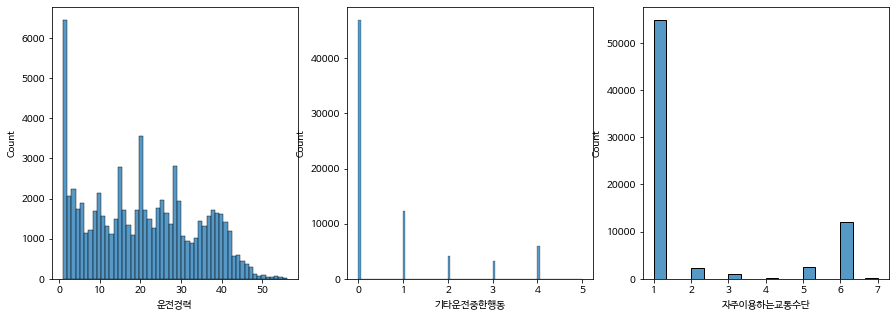

In [ ]:
# histogram으로 이상치 검토
plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(sur_18_20['운전경력'], ax=ax[0]);
sns.histplot(sur_18_20['기타운전중한행동'], ax=ax[1]);
sns.histplot(sur_18_20['자주이용하는교통수단'], ax=ax[2]);

In [16]:
# '기타운전중한행동'에서 5번 항목 삭제, '자주이용하는교통수단'에서 7번 항목 삭제 - 총 132개
index_names = sur_18_20[sur_18_20['기타운전중한행동'] == 5].index
index_names2 = sur_18_20[sur_18_20['자주이용하는교통수단'] == 7].index

sur_18_20.drop(index_names, inplace = True)
sur_18_20.drop(index_names2, inplace = True)

# 전체 응답 항목이 중복인 데이터 삭제 - 총 44개
sur_18_20 = sur_18_20.drop_duplicates(keep = 'first')

# 결과 확인
sur_18_20.shape

(72676, 49)

## **2. 타겟 설정**

### **2-1. 타겟 설정 방향성**

 - 2018 ~ 2020년도의 교통 의식수준 설문조사 및 지역별 교통 관련 자료를 기반으로 특정 사람이 설문을 진행한 당해 연도 동안 교통사고 및 교통 법규 위반이 있었는지를 이진 분류하는 모델을 만들 예정

- **타겟 변수 -> '범칙금 부과 여부' 및 '교통사고 여부' 칼럼에 '예'로 응답한 사람**

- Target 컬럼 설정을 위해 '범칙금 부과 여부' 및 '교통사고 여부' 칼럼에 '예'로 응답한 사람의 데이터 값을 1로 하는 (없는 사람은 0) 칼럼 생성

In [17]:
# 데이터 값 1에 해당하는 인원 확인
sur_18_20['물의를일으켰는가'] = sur_18_20['범칙금부과여부(교통법규위반)'] + sur_18_20['교통사고여부']
print(sur_18_20['물의를일으켰는가'].value_counts())

# 4 = 교통사고 및 교통 법규 위반 사례 없음
# 3 = 교통사고 및 교통 법규 위반 사례가 둘 중에 하나 있음
# 2 = 교통사고 및 교통 법규 위반 사례가 둘 다 있음

# 데이터 값을 0과 1로 replace
sur_18_20['물의를일으켰는가'] = sur_18_20['물의를일으켰는가'].replace({4: 0, 3: 1, 2: 1})
print(sur_18_20['물의를일으켰는가'].value_counts())

# 기준모델 점검
sur_18_20['물의를일으켰는가'].value_counts(normalize = True)

# 1 = 교통사고 및 교통 법규 위반 사례가 적어도 하나 있음
# 0 = 교통사고 및 교통 법규 위반 사례 없음

4    62798
3     8916
2      962
Name: 물의를일으켰는가, dtype: int64
0    62798
1     9878
Name: 물의를일으켰는가, dtype: int64


0    0.864082
1    0.135918
Name: 물의를일으켰는가, dtype: float64

## **3. 데이터 라벨링**

- 코드로 처리되어 있는 데이터를 텍스트로 변경 (데이터 이해 목적)

In [18]:
# 내용 이해를 위한 코드의 텍스트 화
sur_18_20['성별'] = sur_18_20['성별'].replace({1: '남성',
                                            2: '여성'})

sur_18_20['연령대'] = sur_18_20['연령대'].replace({1: '20대',
                                                2: '30대',
                                                3: '40대',
                                                4: '50대',
                                                5: '60대 이상'})

rep_li_4 = ['정지선중요도', '점등중요도', '신호중요도', '안전띠중요도(일반도로)', '안전띠중요도(고속도로)', '음주운전인식', '규정속도위반인식', '운전중스마트폰사용여부인식', 
            '회전교차로우선순위인식', '횡단보도이용간신호위반인식', '횡단보도이용간스마트폰사용인식', '무단횡단인식']

sur_18_20[rep_li_4] = sur_18_20[rep_li_4].replace({1: '전혀 그렇지 않다',
                                                   2: '그렇지 않다',
                                                   3: '보통이다',
                                                   4: '그렇다',
                                                   5: '매우 그렇다'})
# -> 맵핑할 때 순서 반대로

rep_li_5 = ['허용가능한과속수준(고속도로)', '허용가능한과속수준(생활도로)']

sur_18_20[rep_li_5] = sur_18_20[rep_li_5].replace({1: '속도 준수',
                                                   2: '5km/h 초과',
                                                   3: '10km/h 초과',
                                                   4: '15km/h 초과',
                                                   5: '20km/h 초과'})

sur_18_20['기타운전중한행동'] = sur_18_20['기타운전중한행동'].replace({1: '문자 및 SNS 사용',
                                                              2: '핸드폰 통화(한 손 사용)',
                                                              3: '핸즈프리 통화',
                                                              4: '내비게이션 조작',
                                                              5: 'DMB 등 영상 시청'})

sur_18_20['자주이용하는교통수단'] = sur_18_20['자주이용하는교통수단'].replace({1: '승용차 자차 운전',
                                                                    2: '승용차 동승',
                                                                    3: '자전거',
                                                                    4: '오토바이',
                                                                    5: '도보',
                                                                    6: '대중교통'})

sur_18_20['회전교차로이용여부'] = sur_18_20['회전교차로이용여부'].replace({1: '예',
                                                                2: '아니오'})

sur_18_20['운전속도인식(타인대비)'] = sur_18_20['운전속도인식(타인대비)'].replace({1: '심히 저속',
                                                                        2: '저속',
                                                                        3: '보통이다',
                                                                        4: '과속',
                                                                        5: '심히 과속'})

sur_18_20['음주여부'] = sur_18_20['음주여부'].replace({1: '술을 전혀 마시지 않는다',
                                                  2: '술을 마시지만 지난 30일 간 마시지 않았다',
                                                  3: '한번',
                                                  4: '종종(4회) 이하',
                                                  5: '주기적(5회 이상)'})

rep_li_1 = ['교통안전중요성', '교통안전중요성(지인)', '혈중알콜농도강화법안지지도']

sur_18_20[rep_li_1] = sur_18_20[rep_li_1].replace({1: '강한 부정',
                                                   2: '부정',
                                                   3: '긍정',
                                                   4: '강한 긍정',
                                                   5: '모르겠음'})
# -> 맵핑할 때 순서 반대로

rep_li_2 = ['제한속도하향법안지지도', '스마트폰활용금지법안지지도']

sur_18_20[rep_li_2] = sur_18_20[rep_li_2].replace({1: '강한 반대',
                                                   2: '반대',
                                                   3: '지지',
                                                   4: '강한 지지',
                                                   5: '모르겠음'})
# -> 맵핑할 때 순서 반대로

# 횟수를 답변하는 답변에 가중치 부여
rep_li_3 = ['정지선위반여부', '차로변경점등위반여부', '신호위반여부', '안전띠미착용여부(운전석,일반도로)', '안전띠미착용여부(조수석,일반도로)', '안전띠미착용여부(뒷자석,일반도로)',
            '안전띠미착용여부(운전석,고속도로)', '안전띠미착용여부(조수석,고속도로)', '안전띠미착용여부(뒷자석,고속도로)', '음주운전여부', '규정속도위반여부',
            '운전중스마트폰사용여부(일반도로)', '운전중스마트폰사용여부(고속도로)', '회전교차로우선진입여부', '횡단보도이용간신호위반여부', '횡단보도이용간스마트폰사용여부', '무단횡단여부']

sur_18_20[rep_li_3] = sur_18_20[rep_li_3].replace({1: 0,
                                                   2: 1,
                                                   3: 2.5,
                                                   4: 4.5,
                                                   5: 8})

# Target column을 생성 한 이후 불필요해진 column drop 
sur_18_20 = sur_18_20.drop(columns = ['교통사고여부', '범칙금부과여부(교통법규위반)'])

# 결과 확인
sur_18_20.head(3)

,시군구,성별,연령대,교통안전중요성,교통안전중요성(지인),운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,"안전띠미착용여부(운전석,일반도로)","안전띠미착용여부(조수석,일반도로)","안전띠미착용여부(뒷자석,일반도로)",안전띠중요도(일반도로),"안전띠미착용여부(운전석,고속도로)","안전띠미착용여부(조수석,고속도로)","안전띠미착용여부(뒷자석,고속도로)",안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,운전속도인식(타인대비),허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,회전교차로이용여부,회전교차로우선진입여부,회전교차로우선순위인식,횡단보도이용간신호위반여부,횡단보도이용간신호위반인식,횡단보도이용간스마트폰사용여부,횡단보도이용간스마트폰사용인식,무단횡단여부,무단횡단인식,자주이용하는교통수단,실행연도,시도,물의를일으켰는가
0,1,남성,20대,긍정,긍정,1,2.5,매우 그렇다,1.0,매우 그렇다,0.0,매우 그렇다,0.0,0.0,4.5,매우 그렇다,0.0,0.0,0.0,그렇다,술을 전혀 마시지 않는다,0.0,보통이다,긍정,2.5,그렇다,과속,15km/h 초과,5km/h 초과,지지,1.0,0.0,문자 및 SNS 사용,그렇다,반대,예,0.0,보통이다,1.0,매우 그렇다,2.5,보통이다,0.0,매우 그렇다,승용차 자차 운전,2018년,서울특별시,0
1,1,남성,20대,긍정,긍정,2,1.0,그렇다,1.0,매우 그렇다,0.0,매우 그렇다,0.0,1.0,4.5,매우 그렇다,0.0,0.0,4.5,매우 그렇다,술을 전혀 마시지 않는다,4.5,보통이다,긍정,2.5,보통이다,보통이다,10km/h 초과,속도 준수,모르겠음,1.0,1.0,내비게이션 조작,그렇다,반대,예,0.0,그렇다,0.0,매우 그렇다,2.5,그렇지 않다,0.0,그렇다,승용차 자차 운전,2018년,서울특별시,1
2,1,남성,20대,긍정,긍정,2,1.0,매우 그렇다,2.5,그렇다,0.0,매우 그렇다,0.0,0.0,2.5,매우 그렇다,0.0,0.0,0.0,매우 그렇다,술을 전혀 마시지 않는다,1.0,보통이다,긍정,0.0,보통이다,보통이다,10km/h 초과,5km/h 초과,강한 지지,0.0,0.0,0,그렇다,반대,예,1.0,그렇다,2.5,매우 그렇다,4.5,보통이다,0.0,매우 그렇다,승용차 자차 운전,2018년,서울특별시,1


In [ ]:
# 데이터 내보내기
sur_18_20.to_csv(PATH + "sur_18_20.csv", header = True, index = False)

## **4. 데이터 추가 취합**

### **4-1. 2018 ~ 20년도 교통 안전영역 현황 데이터 취합**

출처 : https://mdis.kostat.go.kr/extract/extYearsSurvSearchNew.do?curMenuNo=UI_POR_P9012

(키워드 : 건설/교통·물류 -> 교통문화실태조사)

In [19]:
# 파일명 설정
CSV_LIST = ['교통안전영역2018.csv', '교통안전영역2019.csv', '교통안전영역2020.csv']

# 불러오기
car_saf_2018 = pd.read_csv(PATH + CSV_LIST[0], sep = ',', encoding = "cp949")
car_saf_2019 = pd.read_csv(PATH + CSV_LIST[1], sep = ',', encoding = "cp949")
car_saf_2020 = pd.read_csv(PATH + CSV_LIST[2], sep = ',', encoding = "cp949")

# 형태 확인
car_saf_2018.shape, car_saf_2019.shape, car_saf_2020.shape

((229, 15), (229, 12), (229, 12))

In [20]:
# 18년도 column drop list 
saf_drop_list_18 = ['인구 및 도로연장 당 자동차 교통사고 사망자 수(지수)', '인구 및 도로연장 당 보행자 사망자 수(지수)', '사업용 자동차 대수 및 도로연장 당 교통사고 사망자 수(지수)', '그룹별(도시규모)',
                    '사업용자동차 등록대수(대)_2018.6.기준', '자동차 교통사고 사망자 수(명)_2017.7.~2018.6.', '보행자 사망자 수(명)_2017.7.~2018.6.', '사업용 자동차 사망자 수(명)_2017.7.~2018.6.']

# 19년도 column drop list 
saf_drop_list_19 = ['시군구 그룹', '<2019.6.기준> 사업용자동차 등록대수(대)', '<2018.7.~2019.6.> 자동차 교통사고 사망자 수(명)', '<2018.7.~2019.6.> 보행자 사망자 수(명)', '<2018.7.~2019.6.> 사업용 자동차 사망자 수(명)']

# 20년도 column drop list 
saf_drop_list_20 = ['그룹별(도시규모)', '<2020.6.기준> 사업용자동차 등록대수(대)', '<2019.7.~2020.6.> 자동차 교통사고 사망자 수(명)', '<2019.7.~2020.6.> 보행자 사망자 수(명)', '<2019.7.~2020.6.> 사업용 자동차 사망자 수(명)']

# drop 적용
car_saf_2018 = car_saf_2018.drop(columns = saf_drop_list_18, axis = 1)
car_saf_2019 = car_saf_2019.drop(columns = saf_drop_list_19, axis = 1)
car_saf_2020 = car_saf_2020.drop(columns = saf_drop_list_20, axis = 1)

# 형태 확인
car_saf_2018.shape, car_saf_2019.shape, car_saf_2020.shape

((229, 7), (229, 7), (229, 7))

In [22]:
# 3개년 자료 column명 변경 (간략화)
col_rename_saf = ['시군구', '주민등록인구(명)', '도로연장(m)', '교통안전전문성확보여부', '교통안전정책이행정도', '교통안전부문예산확보노력', '지자체사업용자동차안전관리수준']

# 변경 적용
car_saf_2018.columns = col_rename_saf
car_saf_2019.columns = col_rename_saf
car_saf_2020.columns = col_rename_saf

# 시군구 구분 코드 변경
car_saf_2019['시군구'] = car_saf_2019['시군구'].replace({'A': 230,
                                                   'B': 231,
                                                   'C': 232,
                                                   'D': 233})

# 시군구 별 평균 값 산출 및 적용하여 2019년도 데이터 업데이트
car_saf_2019 = car_saf_2019.groupby(['시군구'], as_index = False).mean()

# 데이터 통합 전 조사 실행 연도 column 생성
car_saf_2018['실행연도'] = '2018년'
car_saf_2019['실행연도'] = '2019년'
car_saf_2020['실행연도'] = '2020년'

# 형태 확인
car_saf_2019.head()

,시군구,주민등록인구(명),도로연장(m),교통안전전문성확보여부,교통안전정책이행정도,교통안전부문예산확보노력,지자체사업용자동차안전관리수준,실행연도
0,230,609092.034483,796256.758621,3.027586,2.690340,1.600575,0.734381,2019년
1,231,160661.306122,598214.979592,2.206122,2.090213,1.158304,0.534617,2019년
2,232,53582.487805,395993.207317,1.810976,1.534908,0.722336,0.313303,2019년
3,233,317672.695652,305384.565217,2.042029,1.843511,0.909525,0.554946,2019년


In [23]:
# 3개년도 데이터 합치기
car_saf_18_20 = pd.concat([car_saf_2018,car_saf_2019,car_saf_2020])

# 결과확인
car_saf_18_20.shape

(462, 8)

### **4-2. 2018 ~ 20년도 교통 문화지수 조사 데이터 취합**

출처 : https://tmacs.kotsa.or.kr/web/TG/TG100/TG0800/Tg0800_02_Re1.jsp?mid=S1286

In [25]:
# 파일명 설정
CSV_LIST = ['교통안전정보 영역별조사결과_2018.csv', '교통안전정보 영역별조사결과_2019.csv', '교통안전정보 영역별조사결과_2020.csv']

# 불러오기
gov_cul_2018 = pd.read_csv(PATH + CSV_LIST[0], sep = ',')
gov_cul_2019 = pd.read_csv(PATH + CSV_LIST[1], sep = ',')
gov_cul_2020 = pd.read_csv(PATH + CSV_LIST[2], sep = ',')

# 형태 확인
gov_cul_2018.shape, gov_cul_2019.shape, gov_cul_2020.shape

((229, 7), (229, 6), (229, 7))

In [26]:
# 불필요한 칼럼 제거
gov_cul_2018 = gov_cul_2018.drop(columns = ['시도', '시군구'], axis=1)
gov_cul_2019 = gov_cul_2019.drop(columns = ['시도'], axis=1)
gov_cul_2020 = gov_cul_2020.drop(columns = ['구분', '시군구'], axis=1)

# 형태 확인
gov_cul_2018.shape, gov_cul_2019.shape, gov_cul_2020.shape

((229, 5), (229, 5), (229, 5))

In [27]:
# 3개년 자료 column명 변경 (간략화)
col_rename_gov_18_20 = ['시군구', '운전행태영역(55점)', '교통안전영역(25점)', '보행형태영역(20점)', '실행연도']
col_rename_gov_19 = ['운전행태영역(55점)', '교통안전영역(25점)', '보행형태영역(20점)', '실행연도', '시군구']

# 변경 적용
gov_cul_2018.columns = col_rename_gov_18_20
gov_cul_2019.columns = col_rename_gov_19
gov_cul_2020.columns = col_rename_gov_18_20

# 시군구 별 평균 값 산출 및 적용하여 2019년도 데이터 업데이트
gov_cul_2019 = gov_cul_2019.groupby(['시군구'], as_index = False).mean()

# 데이터 통합 전 조사 실행 연도 column 생성
gov_cul_2019['실행연도'] = '2019년'

# 3개년도 데이터 합치기
gov_cul_18_20 = pd.concat([gov_cul_2018, gov_cul_2019, gov_cul_2020])

# 결과확인
gov_cul_18_20.head()

,시군구,운전행태영역(55점),교통안전영역(25점),보행형태영역(20점),실행연도
0,108,48.26,9.61,17.21,2018년
1,122,46.44,11.26,15.33,2018년
2,109,48.83,10.61,17.25,2018년
3,112,47.42,11.01,17.12,2018년
4,111,45.88,16.30,17.55,2018년


### **4-3. 2018 ~ 20년도 시/군/구 별 사고 다발 지점 관련 데이터 취합**

출처 : https://tmacs.kotsa.or.kr/web/TG/TG300/TG3100/Tg2127.jsp?mid=S1810

In [32]:
# 파일명 설정
CSV_LIST = ['사고누적지 사고지표_2018.csv', '사고누적지 사고지표_2019.csv', '사고누적지 사고지표_2020.csv']

# 불러오기
car_acc_2018 = pd.read_csv(PATH + CSV_LIST[0], sep = ',')
car_acc_2019 = pd.read_csv(PATH + CSV_LIST[1], sep = ',')
car_acc_2020 = pd.read_csv(PATH + CSV_LIST[2], sep = ',')

# 형태 확인
car_acc_2018.shape, car_acc_2019.shape, car_acc_2020.shape

((229, 12), (229, 12), (229, 12))

In [33]:
# 18,20년도 column drop list 
car_acc_drop_list_18_20 = ['시도', '시군구', '사고다발지역개수']

# 19년도 column drop list 
car_acc_drop_list_19 = ['시도', '시도군', '코드']

# drop 적용
car_acc_2018 = car_acc_2018.drop(columns = car_acc_drop_list_18_20, axis = 1)
car_acc_2019 = car_acc_2019.drop(columns = car_acc_drop_list_19, axis = 1)
car_acc_2020 = car_acc_2020.drop(columns = car_acc_drop_list_18_20, axis = 1)

# column 이름 변경
car_acc_2018.rename(columns = {'코드' : '시군구'}, inplace = True)
car_acc_2020.rename(columns = {'코드' : '시군구'}, inplace = True)

# 형태 확인
car_acc_2018.shape, car_acc_2019.shape, car_acc_2020.shape

((229, 9), (229, 9), (229, 9))

In [34]:
# 시군구 별 평균 값 산출 및 적용하여 2019년도 데이터 업데이트
car_acc_2019 = car_acc_2019.groupby(['시군구'], as_index = False).mean()

# 데이터 통합 전 조사 실행 연도 column 생성
car_acc_2019['실행연도'] = '2019년'

# 3개년도 데이터 합치기
car_acc_18_20 = pd.concat([car_acc_2018, car_acc_2019, car_acc_2020])

# 형태 확인
car_acc_18_20.head()

,시군구,경상발생건수(건),부상발생건수(건),경상사상자수(명),부상사상자수(명),다발도지표,심각도지표,통합지수,실행연도
0,108,839.0,18.0,1470.0,36.0,1.138,1.653,1.447,2018년
1,122,35.0,0.0,64.0,1.0,0.930,1.381,1.201,2018년
2,109,399.0,5.0,686.0,8.0,1.185,1.702,1.495,2018년
3,112,195.0,5.0,379.0,16.0,1.046,1.611,1.385,2018년
4,111,462.0,13.0,874.0,41.0,1.168,1.794,1.543,2018년


### **4-4. 2018 ~ 20년도 시/군/구 별 자동차 등록 수 관련 데이터 취합**

출처 : http://taas.koroad.or.kr/web/shp/sbm/initUnityAnalsSys.do?menuId=WEB_KMP_OVT_UAS

In [35]:
# 파일명 설정
CSV_LIST = ['시군구별 자동차 등록대수_2018.csv', '시군구별 자동차 등록대수_2019.csv', '시군구별 자동차 등록대수_2020.csv']

# 불러오기
car_en_2018 = pd.read_csv(PATH + CSV_LIST[0], sep = ',')
car_en_2019 = pd.read_csv(PATH + CSV_LIST[1], sep = ',')
car_en_2020 = pd.read_csv(PATH + CSV_LIST[2], sep = ',')

# 시군구 별 평균 값 산출 및 적용하여 2019년도 데이터 업데이트
car_en_2019 = car_en_2019.groupby(['시군구'], as_index=False).mean()

# 데이터 통합 전 조사 실행 연도 column 생성
car_en_2019['실행연도'] = '2019년'

# 3개년도 데이터 합치기
car_en_18_20 = pd.concat([car_en_2018, car_en_2019, car_en_2020])

# 형태 확인
car_en_18_20.head()

,시군구,실행연도,승용_관용,승용_자가용,승용_영업용,승합_관용,승합_자가용,승합_영업용,화물_관용,화물_자가용,화물_영업용,특수_관용,특수_자가용,특수_영업용,이륜_관용,이륜_자가용,농기계_계
0,108,2018년,145.0,81193.0,2286.0,130.0,3192.0,609.0,213.0,17280.0,1370.0,19.0,180.0,312.0,114.0,9037.0,5276.0
1,122,2018년,53.0,9638.0,87.0,42.0,532.0,34.0,80.0,3438.0,83.0,3.0,23.0,23.0,23.0,2543.0,2660.0
2,109,2018년,101.0,34529.0,687.0,67.0,1558.0,115.0,117.0,6621.0,382.0,9.0,64.0,169.0,37.0,3206.0,1606.0
3,112,2018년,107.0,23812.0,415.0,101.0,1011.0,103.0,152.0,6321.0,147.0,6.0,47.0,26.0,73.0,3129.0,4022.0
4,111,2018년,101.0,28647.0,928.0,82.0,1395.0,143.0,94.0,5476.0,242.0,6.0,82.0,73.0,53.0,3254.0,804.0


### **4-5. 2018 ~ 20년도 교통 안전계획 추진실적 데이터 취합**

출처 : https://tmacs.kotsa.or.kr/web/TG/TG200/TG2200/Tg2003.jsp?mid=S2305#

In [29]:
# 불러오기
saf_plan_18_20 = pd.read_csv(PATH + '지역 교통안전 시행계획 추진실적_2018~2020.csv', sep = ',')

# 형태 확인
saf_plan_18_20.head(3)

,시도,(추진)시설개선(16점),(추진)사업용 자동차 안전관리(10점),(추진)사업용 자동차 안전관리(12점),(추진)유관기관 간 협력(5점),(추진)우수시책(5점),(사망)교통사고 사망자목표달성률(10점),(사망)교통사고사망자수 증감률(10점),(사망)보행자 교통사고 사망자 증감률(10점),(사망)사업용자동차 교통사고 사망자 증감률(10점),(문화)운전행태 준수율 및 향상률(5점),(문화)보행행태 준수율 및 향상률(5점),실행연도
0,서울특별시,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8,2018년
1,부산광역시,13.8,11.4,9.1,4.3,4.5,9.6,7,7,8,4.5,2.3,2018년
2,대구광역시,14.1,10.2,10.4,4.7,4.4,9.7,8,10,8,4.9,2.3,2018년


### **4-6. 하나의 데이터로 모두 통합**

- 4-1 ~ 4-4를 하나의 데이터로 통합하며 4-5는 가장 처음 활용한 설문조사 데이터와 통합

In [36]:
# 4-1.데이터와 4-2.데이터 merge
add_data_2 = pd.merge(car_saf_18_20, gov_cul_18_20, how = 'right', on = ['시군구', '실행연도'])
add_data_2.head(3)

,시군구,주민등록인구(명),도로연장(m),교통안전전문성확보여부,교통안전정책이행정도,교통안전부문예산확보노력,지자체사업용자동차안전관리수준,실행연도,운전행태영역(55점),교통안전영역(25점),보행형태영역(20점)
0,108,212989.0,913165.0,0.7,0.0,0.0,0.1,2018년,48.26,9.61,17.21
1,122,28596.0,386401.0,3.0,2.7,2.0,0.8,2018년,46.44,11.26,15.33
2,109,91718.0,442186.0,0.0,0.0,0.0,0.1,2018년,48.83,10.61,17.25


In [37]:
# 4-3.데이터와 4-4.데이터 merge
add_data_3 = pd.merge(car_acc_18_20, car_en_18_20, how = 'right', on = ['시군구', '실행연도'])
add_data_3.head(3)

,시군구,경상발생건수(건),부상발생건수(건),경상사상자수(명),부상사상자수(명),다발도지표,심각도지표,통합지수,실행연도,승용_관용,승용_자가용,승용_영업용,승합_관용,승합_자가용,승합_영업용,화물_관용,화물_자가용,화물_영업용,특수_관용,특수_자가용,특수_영업용,이륜_관용,이륜_자가용,농기계_계
0,108,839.0,18.0,1470.0,36.0,1.138,1.653,1.447,2018년,145.0,81193.0,2286.0,130.0,3192.0,609.0,213.0,17280.0,1370.0,19.0,180.0,312.0,114.0,9037.0,5276.0
1,122,35.0,0.0,64.0,1.0,0.930,1.381,1.201,2018년,53.0,9638.0,87.0,42.0,532.0,34.0,80.0,3438.0,83.0,3.0,23.0,23.0,23.0,2543.0,2660.0
2,109,399.0,5.0,686.0,8.0,1.185,1.702,1.495,2018년,101.0,34529.0,687.0,67.0,1558.0,115.0,117.0,6621.0,382.0,9.0,64.0,169.0,37.0,3206.0,1606.0


In [38]:
# 최종 merge
add_data = pd.merge(add_data_2, add_data_3, how='right', on=['시군구', '실행연도'])
add_data.head(3)

,시군구,주민등록인구(명),도로연장(m),교통안전전문성확보여부,교통안전정책이행정도,교통안전부문예산확보노력,지자체사업용자동차안전관리수준,실행연도,운전행태영역(55점),교통안전영역(25점),보행형태영역(20점),경상발생건수(건),부상발생건수(건),경상사상자수(명),부상사상자수(명),다발도지표,심각도지표,통합지수,승용_관용,승용_자가용,승용_영업용,승합_관용,승합_자가용,승합_영업용,화물_관용,화물_자가용,화물_영업용,특수_관용,특수_자가용,특수_영업용,이륜_관용,이륜_자가용,농기계_계
0,108,212989.0,913165.0,0.7,0.0,0.0,0.1,2018년,48.26,9.61,17.21,839.0,18.0,1470.0,36.0,1.138,1.653,1.447,145.0,81193.0,2286.0,130.0,3192.0,609.0,213.0,17280.0,1370.0,19.0,180.0,312.0,114.0,9037.0,5276.0
1,122,28596.0,386401.0,3.0,2.7,2.0,0.8,2018년,46.44,11.26,15.33,35.0,0.0,64.0,1.0,0.930,1.381,1.201,53.0,9638.0,87.0,42.0,532.0,34.0,80.0,3438.0,83.0,3.0,23.0,23.0,23.0,2543.0,2660.0
2,109,91718.0,442186.0,0.0,0.0,0.0,0.1,2018년,48.83,10.61,17.25,399.0,5.0,686.0,8.0,1.185,1.702,1.495,101.0,34529.0,687.0,67.0,1558.0,115.0,117.0,6621.0,382.0,9.0,64.0,169.0,37.0,3206.0,1606.0


In [39]:
# 4-5.데이터와 설문조사 데이터 merge
sur_18_20_add = pd.merge(sur_18_20, saf_plan_18_20, how='right', on=['시도', '실행연도'])
sur_18_20_add.head(3)

,시군구,성별,연령대,교통안전중요성,교통안전중요성(지인),운전경력,정지선위반여부,정지선중요도,차로변경점등위반여부,점등중요도,신호위반여부,신호중요도,"안전띠미착용여부(운전석,일반도로)","안전띠미착용여부(조수석,일반도로)","안전띠미착용여부(뒷자석,일반도로)",안전띠중요도(일반도로),"안전띠미착용여부(운전석,고속도로)","안전띠미착용여부(조수석,고속도로)","안전띠미착용여부(뒷자석,고속도로)",안전띠중요도(고속도로),음주여부,음주운전여부,음주운전인식,혈중알콜농도강화법안지지도,규정속도위반여부,규정속도위반인식,운전속도인식(타인대비),허용가능한과속수준(고속도로),허용가능한과속수준(생활도로),제한속도하향법안지지도,운전중스마트폰사용여부(일반도로),운전중스마트폰사용여부(고속도로),기타운전중한행동,운전중스마트폰사용여부인식,스마트폰활용금지법안지지도,회전교차로이용여부,회전교차로우선진입여부,회전교차로우선순위인식,횡단보도이용간신호위반여부,횡단보도이용간신호위반인식,횡단보도이용간스마트폰사용여부,횡단보도이용간스마트폰사용인식,무단횡단여부,무단횡단인식,자주이용하는교통수단,실행연도,시도,물의를일으켰는가,(추진)시설개선(16점),(추진)사업용 자동차 안전관리(10점),(추진)사업용 자동차 안전관리(12점),(추진)유관기관 간 협력(5점),(추진)우수시책(5점),(사망)교통사고 사망자목표달성률(10점),(사망)교통사고사망자수 증감률(10점),(사망)보행자 교통사고 사망자 증감률(10점),(사망)사업용자동차 교통사고 사망자 증감률(10점),(문화)운전행태 준수율 및 향상률(5점),(문화)보행행태 준수율 및 향상률(5점)
0,1,남성,20대,긍정,긍정,1,2.5,매우 그렇다,1.0,매우 그렇다,0.0,매우 그렇다,0.0,0.0,4.5,매우 그렇다,0.0,0.0,0.0,그렇다,술을 전혀 마시지 않는다,0.0,보통이다,긍정,2.5,그렇다,과속,15km/h 초과,5km/h 초과,지지,1.0,0.0,문자 및 SNS 사용,그렇다,반대,예,0.0,보통이다,1.0,매우 그렇다,2.5,보통이다,0.0,매우 그렇다,승용차 자차 운전,2018년,서울특별시,0,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8
1,1,남성,20대,긍정,긍정,2,1.0,그렇다,1.0,매우 그렇다,0.0,매우 그렇다,0.0,1.0,4.5,매우 그렇다,0.0,0.0,4.5,매우 그렇다,술을 전혀 마시지 않는다,4.5,보통이다,긍정,2.5,보통이다,보통이다,10km/h 초과,속도 준수,모르겠음,1.0,1.0,내비게이션 조작,그렇다,반대,예,0.0,그렇다,0.0,매우 그렇다,2.5,그렇지 않다,0.0,그렇다,승용차 자차 운전,2018년,서울특별시,1,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8
2,1,남성,20대,긍정,긍정,2,1.0,매우 그렇다,2.5,그렇다,0.0,매우 그렇다,0.0,0.0,2.5,매우 그렇다,0.0,0.0,0.0,매우 그렇다,술을 전혀 마시지 않는다,1.0,보통이다,긍정,0.0,보통이다,보통이다,10km/h 초과,5km/h 초과,강한 지지,0.0,0.0,0,그렇다,반대,예,1.0,그렇다,2.5,매우 그렇다,4.5,보통이다,0.0,매우 그렇다,승용차 자차 운전,2018년,서울특별시,1,10.2,10.4,9.3,4.4,4.6,9.2,8,8,8,5.0,2.8


In [ ]:
# 데이터 내보내기
add_data.to_csv(PATH + "add_data.csv", header = True, index = False)
sur_18_20_add.to_csv(PATH + "sur_18_20_add.csv", header = True, index = False)